# Simple CNN Model test notebook

Just trying out if the training pipeline works

In [5]:
# Hyperparameters for simulation
nparticles = 1000   # Number of particles
nframes = 8    # Number of steps in the simulation
nposframe = 10    # Number of position per frame
dt = 0.01        # Integration time frame in second (time between two frames)
DGen = 10000        # Diffusion coefficient in nm^2 per s (=0.001 (um^2)/s)
num_steps = nframes*nposframe
# Hyperparameters for image generation
npixel = 64 # number of image pixels
pixelsize = 100 # in nm 
fwhm_psf = 200 # full width half maximum (emulates microscope)
factor_hr = 5 # image high resulution factor
flux = 100 # number of photons per s
poisson_noise = 100 
gaussian_noise = 10
background = 100 # base background value
normalizeValue = 1000 # value by which all samples will be normalized ! Needs to be fixed and the same for all images !



In [6]:
#%load_ext autoreload
%reload_ext autoreload
%autoreload 2
from helpers import *
from simpleCNNModel import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [7]:
# Load the model weights
loaded_model = DiffusionPredictorCNN().to(device)
loaded_model = load_model_weights(loaded_model, "diffusion_model_weights.pth")

model = loaded_model

Model weights loaded from diffusion_model_weights.pth


In [8]:
# Takes 30 seconds to run with N=100 images (on my laptop)
# Takes 16 seconds to run with N=100 images (on my pc)
# Simulated dataset
N = 50  # Number of samples
images, estimatedDs =  generateImagesAndEstimateD(N, nframes, npixel, factor_hr, nposframe, DGen, dt, fwhm_psf, pixelsize,flux, background, poisson_noise, gaussian_noise, normalizeValue)
print(images.shape)
# Add channel dimension to images: (N, 8, 64, 64) -> (N, 8, 1, 64, 64)
images = torch.tensor(images, dtype=torch.float32).unsqueeze(2)
estimatedDs = torch.tensor(estimatedDs, dtype=torch.float32)
print(images.shape)
# Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# uncomment next line if you want to train a new model and note use the previous existing weigths
#model = DiffusionPredictorCNN().to(device)

# Train the model
trained_model, loss_history = train_model(
    model, 
    images, 
    estimatedDs, 
    device,
    epochs=100, 
    batch_size=16, 
    learning_rate=0.001, 
)

# Save the model weights
#save_model_weights(trained_model, "diffusion_model_weights.pth")



(50, 8, 64, 64)
torch.Size([50, 8, 1, 64, 64])
Epoch 1/100, Loss: 139407173.7600
Epoch 2/100, Loss: 139364020.8800
Epoch 3/100, Loss: 139314619.8400
Epoch 4/100, Loss: 139264616.0000
Epoch 5/100, Loss: 139213839.3600
Epoch 6/100, Loss: 139158189.7600
Epoch 7/100, Loss: 139100532.4800
Epoch 8/100, Loss: 139038587.5200
Epoch 9/100, Loss: 138972595.2000
Epoch 10/100, Loss: 138908593.2800
Epoch 11/100, Loss: 138833908.8000
Epoch 12/100, Loss: 138763275.5200
Epoch 13/100, Loss: 138692184.3200
Epoch 14/100, Loss: 138612787.2000
Epoch 15/100, Loss: 138532919.0400
Epoch 16/100, Loss: 138451322.7200
Epoch 17/100, Loss: 138356147.5200
Epoch 18/100, Loss: 138270733.6000
Epoch 19/100, Loss: 138176773.1200
Epoch 20/100, Loss: 138087424.9600
Epoch 21/100, Loss: 137986741.1200
Epoch 22/100, Loss: 137887078.4000
Epoch 23/100, Loss: 137780293.2800
Epoch 24/100, Loss: 137674271.1200
Epoch 25/100, Loss: 137567862.0800
Epoch 26/100, Loss: 137460630.8800
Epoch 27/100, Loss: 137347877.6800
Epoch 28/100, Los

In [9]:
# Save the model weights
save_model_weights(trained_model, "diffusion_model_weights.pth")

Model weights saved to diffusion_model_weights.pth


In [10]:
# Load the model weights
loaded_model = DiffusionPredictorCNN().to(device)
loaded_model = load_model_weights(loaded_model, "diffusion_model_weights.pth")

Model weights loaded from diffusion_model_weights.pth


Image loaded from refImage.npy
Real D value: 13837. Model estimated value: 0.0


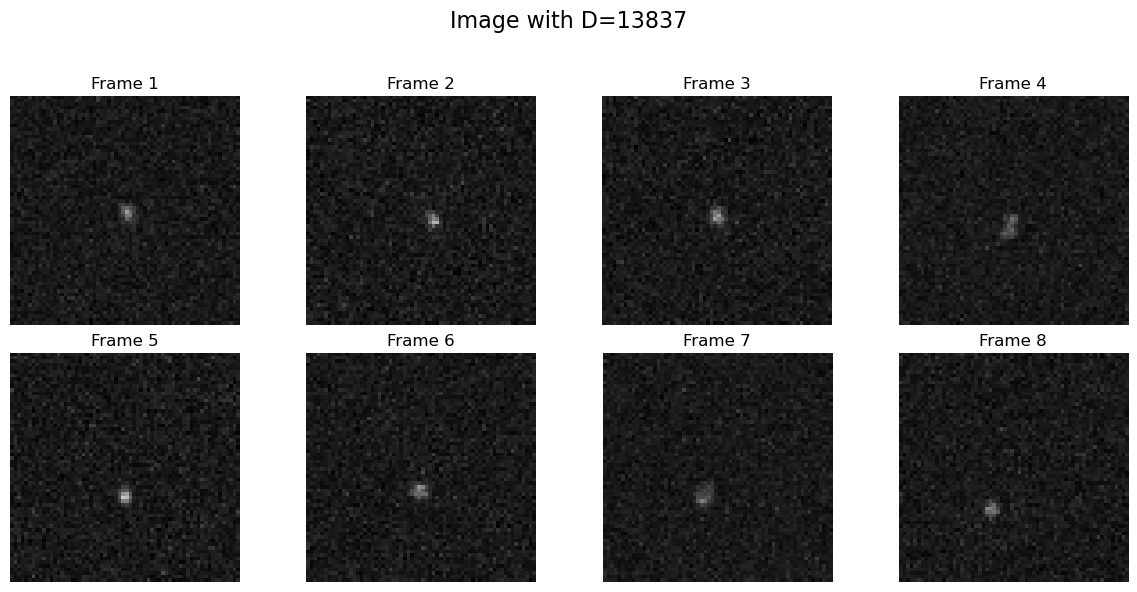

In [15]:
# Uncomment these 3 lines to generate a new reference image
#singleIm, singleestimatedDs = generateImagesAndEstimateD(1, nframes, npixel, factor_hr, nposframe, DGen, dt, fwhm_psf, pixelsize,flux, background, poisson_noise, gaussian_noise, normalizeValue)
#im, estD = singleIm[0,:], singleestimatedDs[0]
#save_image(im,"refImage.npy") 


im = load_image("refImage.npy")
estD = 13837

modelEstimation = predict_diffusion_coefficients(loaded_model, im,device )

print(f"Real D value: {estD}. Model estimated value: {round(modelEstimation,0)}")
plot_image_frames(im,f"Image with D={estD}")



In [16]:
# Load the trained model weights
loaded_model = DiffusionPredictorCNN().to(device)
loaded_model = load_model_weights(loaded_model, "diffusion_model_weights.pth")
print("Loaded trained model weights for testing.")

N_test = 50  # Number of test 
test_images, test_estimatedDs = generateImagesAndEstimateD(
    N_test, nframes, npixel, factor_hr, nposframe, DGen, dt, fwhm_psf, pixelsize, flux, background, poisson_noise, gaussian_noise, normalizeValue
)

# Add channel dimension to test images
test_images = torch.tensor(test_images, dtype=torch.float32).unsqueeze(2).to(device)  # Shape: (N_test, 8, 1, 64, 64)
test_estimatedDs = torch.tensor(test_estimatedDs, dtype=torch.float32).to(device)

print(f"Test images shape: {test_images.shape}")
print(f"Test labels shape: {test_estimatedDs.shape}")

# Predict diffusion coefficients 
predicted_Ds = predict_diffusion_coefficients(loaded_model, test_images, device)

# Compare predictions to ground truth
for i in range(len(predicted_Ds)):
    print(f"Real D: {test_estimatedDs[i].item():.2f}, Predicted D: {predicted_Ds[i]:.2f}")


Model weights loaded from diffusion_model_weights.pth
Loaded trained model weights for testing.
Test images shape: torch.Size([50, 8, 1, 64, 64])
Test labels shape: torch.Size([50])


ValueError: too many values to unpack (expected 5)